In [1]:
import pandas as pd
import numpy as np
import math
from os.path import exists
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from decimal import Decimal
from matplotlib.colors import BoundaryNorm
from matplotlib.patches import Rectangle

from scipy import stats
import statsmodels.stats.multitest
from decimal import Decimal
import collections

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.multitest import multipletests

import pickle 
from matplotlib import rcParams

import warnings
warnings.filterwarnings('ignore')

import utils_statistics

# 1. Data Loading

In [3]:
dystonia_genetics   = pd.read_csv('dataset/genetic_dystonia_pallidal_neuron_activity.csv')
dystonia_genetics   = dystonia_genetics[dystonia_genetics.patient!="patient1"] # removing benign-SGCE case

# fill np.nan values with 0
dystonia_genetics   = dystonia_genetics.fillna(0)

gene_class_original = {'AOPEP':1, 'GNAL'  :2, 'KMT2B':3,
                       'PANK2':4, 'PLA2G6':5, 'SGCE' :6, 
                       'THAP1':7, 'TOR1A' :8, 'VPS16':9}

genes               = ['AOPEP', 'GNAL', 'KMT2B', 'PANK2', 'PLA2G6', 'SGCE', 'THAP1', 'TOR1A', 'VPS16'];
classification      = ''.join(map(str, [gene_class_original[gene] for gene in genes]))
gene_class_map      = dict(zip(genes, [number+1 for number in range(len(genes))]))

gene_data           = {}
gene_data["AOPEP"]  = dystonia_genetics[dystonia_genetics.gene == "AOPEP"]
gene_data["GNAL"]   = dystonia_genetics[dystonia_genetics.gene == "GNAL"]
gene_data["KMT2B"]  = dystonia_genetics[dystonia_genetics.gene == "KMT2B"]
gene_data["PANK2"]  = dystonia_genetics[dystonia_genetics.gene == "PANK2"]
gene_data["PLA2G6"] = dystonia_genetics[dystonia_genetics.gene == "PLA2G6"]
gene_data["SGCE"]   = dystonia_genetics[dystonia_genetics.gene == "SGCE"]
gene_data["THAP1"]  = dystonia_genetics[dystonia_genetics.gene == "THAP1"]
gene_data["TOR1A"]  = dystonia_genetics[dystonia_genetics.gene == "TOR1A"]
gene_data["VPS16"]  = dystonia_genetics[dystonia_genetics.gene == "VPS16"]

# 2. Stratify by Thresholding

In [5]:
def correct_pvalues(group):
    group['pvalue_corrected'] = multipletests(group['pvalue'], method='fdr_bh')[1]
    return group
    
def fisher_exact_text(dataset, group_feature, comparison_feature):
    from scipy.stats import fisher_exact
    
    fe_res = pd.DataFrame(columns=["group_1","group_2","pvalue"])
    groups = list(dataset[group_feature].unique())
    for i in range(len(groups)):
        for j in range(len(groups)):
            row               = {}
            group_1           = groups[i]
            group_2           = groups[j]
            if(group_1!=group_2):
                x         = pd.crosstab(index=dataset[group_feature], columns=dataset[comparison_feature])
                con_table = x.loc[[group_1, group_2]]
                pvalue    = stats.fisher_exact(con_table, alternative="greater").pvalue
                row["group_1"]    = group_1
                row["group_2"]    = group_2
                row["pvalue"]     = pvalue
                fe_res.loc[len(fe_res)] = row

    # apply correction for each gene individually
    fe_res = fe_res.groupby('group_1').apply(correct_pvalues)
    fe_res.reset_index(drop=True, inplace=True)
    fe_res = fe_res[fe_res.pvalue_corrected<=0.05]
    return fe_res

In [6]:
# significance denotes that group_1 gene presented the selected phenomena significantly less than the group_2 gene

df_bursting    = fisher_exact_text(dystonia_genetics, group_feature="gene", comparison_feature="is_bursting")
df_tonicity    = fisher_exact_text(dystonia_genetics, group_feature="gene", comparison_feature="is_tonic")
df_irregular   = fisher_exact_text(dystonia_genetics, group_feature="gene", comparison_feature="is_irregular")
df_oscillatory = fisher_exact_text(dystonia_genetics, group_feature="gene", comparison_feature="is_oscillatory")

In [7]:
df_bursting

,group_1,group_2,pvalue,pvalue_corrected
2,AOPEP,KMT2B,5.600881e-06,2.240352e-05
3,AOPEP,TOR1A,2.291631e-02,3.055509e-02
4,AOPEP,VPS16,1.597924e-02,2.556678e-02
5,AOPEP,SGCE,2.411595e-06,1.929276e-05
6,AOPEP,GNAL,5.354551e-05,1.427880e-04
7,AOPEP,PLA2G6,7.883600e-05,1.576720e-04
25,PANK2,KMT2B,1.068462e-07,4.273848e-07
26,PANK2,TOR1A,2.193348e-02,2.924463e-02
27,PANK2,VPS16,1.294384e-02,2.071015e-02
28,PANK2,SGCE,9.504921e-10,7.603937e-09


# 2.1 Define The Thresholds

In [9]:
def define_boundary(data, g1, g2, alternative):
    from scipy.stats import fisher_exact
    from scipy.stats import barnard_exact
    gup_t     = data[g1]
    gdown_t   = data[g2]
    iteration = gup_t[1]
    
    if(alternative == "less"):
        for i in range(iteration):
            gup_t_updated     = [gup_t[0]+i, gup_t[1]-i]
            table             = [gup_t_updated, gdown_t]
            statistic, pvalue = fisher_exact(table, alternative='less')
            if(pvalue >= 0.05):
                threshold = (gup_t_updated[1]-1) / np.sum(gup_t_updated) * 100
                break
    else:
        for i in range(iteration):
            gdown_t_updated   = [gdown_t[0]-i, gdown_t[1]+i]
            table             = [gup_t, gdown_t_updated]
            statistic, pvalue = fisher_exact(table, alternative='greater')
            if(pvalue >= 0.05):
                threshold = (gdown_t_updated[1]+1) / np.sum(gdown_t_updated) * 100
                break
        
    return threshold

### 2.1.1 Burstiness

In [11]:
ct, ct_percentage  = utils_statistics.create_cross_tab(gene_data, feature="is_bursting")
ct_percentage

{'KMT2B': 42.5531914893617,
 'GNAL': 42.0,
 'SGCE': 39.285714285714285,
 'PLA2G6': 34.319526627218934,
 'VPS16': 20.28985507246377,
 'TOR1A': 19.12442396313364,
 'THAP1': 14.864864864864865,
 'PANK2': 10.92436974789916,
 'AOPEP': 6.666666666666667}

In [12]:
high_boundary_gene = "PLA2G6"
low_boundary_gene  = "VPS16"


ct["lev_up"]       = [0, 0] 
ct["lev_up"][0]    = ct[high_boundary_gene][0]
ct["lev_up"][1]    = ct[high_boundary_gene][1]
ct["lev_down"]     = [0, 0] 
ct["lev_down"][0]  = ct[low_boundary_gene][0]
ct["lev_down"][1]  = ct[low_boundary_gene][1]

threshold = utils_statistics.define_boundary(data=ct, g1="lev_up", g2="lev_down", alternative="less")
threshold

26.627218934911244

### 2.1.2 Tonicity

In [14]:
ct, ct_percentage  = utils_statistics.create_cross_tab(gene_data, feature="is_tonic")
ct_percentage

{'THAP1': 58.108108108108105,
 'PANK2': 44.537815126050425,
 'AOPEP': 42.22222222222222,
 'VPS16': 22.89855072463768,
 'TOR1A': 22.811059907834103,
 'KMT2B': 19.148936170212767,
 'GNAL': 16.0,
 'PLA2G6': 13.609467455621301,
 'SGCE': 8.241758241758241}

In [15]:
high_boundary_gene = "AOPEP"
low_boundary_gene  = "VPS16"


ct["lev_up"]       = [0, 0] 
ct["lev_up"][0]    = ct[high_boundary_gene][0]
ct["lev_up"][1]    = ct[high_boundary_gene][1]
ct["lev_down"]     = [0, 0] 
ct["lev_down"][0]  = ct[low_boundary_gene][0]
ct["lev_down"][1]  = ct[low_boundary_gene][1]

threshold = utils_statistics.define_boundary(data=ct, g1="lev_up", g2="lev_down", alternative="less")
threshold

33.33333333333333

# 3. Stratify by Distance

In [17]:
from scipy.spatial.distance import jensenshannon
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

In [18]:
features_all        = ['firing_rate', 'firing_regularity', 'cv', 'lv', 'isi_mean', 'isi_std',
                       'isi_skewness', 'isi_rho', 'pause_index', 'pause_ratio',
                       'asymmetry_index', 'burst_index', 'burst_average_spikes', 'burst_spike_proportion',
                       'burst_duration', 'inter_burst_duration', 'burst_freq', 'burst_count',
                       'pause_freq', 'pause_duration', 'pause_time_proportion',
                       'pause_spike_proportion', 'pause_count', 'oscillation_frequency_delta_band', 'oscillation_frequency_theta_band',
                       'oscillation_frequency_alpha_band', 'oscillation_frequency_beta_band',
                       'oscillation_frequency_gamma_band', 'is_bursting', 'is_tonic',
                       'is_irregular', 'delta_band_oscillatory', 'theta_band_oscillatory',
                       'alpha_band_oscillatory', 'beta_band_oscillatory','gamma_band_oscillatory', 'is_oscillatory']


features_regularity  = ['firing_regularity', 'cv', 'lv', 'isi_std', 'isi_skewness', 'isi_rho', 'pause_index', 'pause_ratio', 'asymmetry_index', 'is_tonic', 'is_irregular']
features_burst       = ['is_bursting', 'burst_index', 'burst_average_spikes', 'burst_spike_proportion','burst_duration', 'inter_burst_duration', 'burst_freq', 'burst_count']
features_pause       = ['pause_freq', 'pause_duration', 'pause_time_proportion','pause_spike_proportion', 'pause_count']
features_oscillation = ['oscillation_frequency_delta_band', 'oscillation_frequency_theta_band','oscillation_frequency_alpha_band', 
                        'oscillation_frequency_beta_band', 'oscillation_frequency_gamma_band', 'delta_band_oscillatory', 'theta_band_oscillatory',
                        'alpha_band_oscillatory', 'beta_band_oscillatory', 'gamma_band_oscillatory', 'is_oscillatory']
features_pattern     = ['is_tonic', 'is_irregular', 'is_bursting', 'is_oscillatory']


In [19]:
js_distances = {} 

for feature in features_all:
    biomarker_distances = pd.DataFrame(data=np.zeros(shape=(len(genes),len(genes))), columns=genes, index=genes)
    for gene1 in genes:
        for gene2 in genes:
            pop1    = gene_data[gene1][feature]
            pop2    = gene_data[gene2][feature]
            bins    = np.linspace(dystonia_genetics[feature].min(), dystonia_genetics[feature].max(), 20)
            pdf1, _ = np.histogram(pop1, bins=bins, density=True)
            pdf2, _ = np.histogram(pop2, bins=bins, density=True)
            jsd     = jensenshannon(pdf1, pdf2)
            biomarker_distances.at[gene1,gene2] = jsd
    js_distances[feature] = biomarker_distances

## 3.1. Burst Scores

In [21]:
burst_scores = pd.DataFrame(data=np.zeros(shape=(len(genes),len(genes))), columns=genes, index=genes)
for feature in features_burst:
    burst_scores = burst_scores.add(js_distances[feature], fill_value=0)

## 3.2. Regularity

In [23]:
regularity_scores = pd.DataFrame(data=np.zeros(shape=(len(genes),len(genes))), columns=genes, index=genes)
for feature in features_regularity:
    regularity_scores = regularity_scores.add(js_distances[feature], fill_value=0)

## 3.3. Neural Pauses

In [25]:
pause_scores = pd.DataFrame(data=np.zeros(shape=(len(genes),len(genes))), columns=genes, index=genes)
for feature in features_pause:
    pause_scores = pause_scores.add(js_distances[feature], fill_value=0)

## 3.4. Neural Oscillations

In [27]:
oscillation_scores = pd.DataFrame(data=np.zeros(shape=(len(genes),len(genes))), columns=genes, index=genes)
for feature in features_oscillation:
    oscillation_scores = oscillation_scores.add(js_distances[feature], fill_value=0)

## 3.5 Pattern

In [29]:
pattern_scores = pd.DataFrame(data=np.zeros(shape=(len(genes),len(genes))), columns=genes, index=genes)
for feature in features_pattern:
    pattern_scores = pattern_scores.add(js_distances[feature], fill_value=0)

## 3.6. Total Scores

In [31]:
scores = pd.DataFrame(data=np.zeros(shape=(len(genes),len(genes))), columns=genes, index=genes)
for feature in features_all:
    scores = scores.add(js_distances[feature], fill_value=0)

<Figure size 640x480 with 0 Axes>

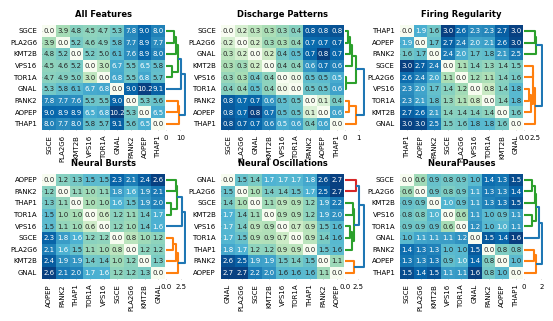

In [32]:
labelsize          = 5
plt.rc('font', serif="Neue Haas Grotesk Text Pro")

fig = plt.figure()
cm = 1/2.54  # centimeters in inches
plt.subplots(figsize=(18*cm, 21*cm))


ax_p1  = plt.subplot2grid((60, 80), (0, 0), colspan=18, rowspan=10)
ax_p1d = plt.subplot2grid((60, 80), (0, 18), colspan=3, rowspan=10)
ax_p2  = plt.subplot2grid((60, 80), (0, 26), colspan=18, rowspan=10)
ax_p2d = plt.subplot2grid((60, 80), (0, 44), colspan=3, rowspan=10)
ax_p3  = plt.subplot2grid((60, 80), (0, 52), colspan=18, rowspan=10)
ax_p3d = plt.subplot2grid((60, 80), (0, 70), colspan=3, rowspan=10)
ax_p4  = plt.subplot2grid((60, 80), (14, 0), colspan=18, rowspan=10)
ax_p4d = plt.subplot2grid((60, 80), (14, 18), colspan=3, rowspan=10)
ax_p5  = plt.subplot2grid((60, 80), (14, 26), colspan=18, rowspan=10)
ax_p5d = plt.subplot2grid((60, 80), (14, 44), colspan=3, rowspan=10)
ax_p6  = plt.subplot2grid((60, 80), (14, 52), colspan=18, rowspan=10)
ax_p6d = plt.subplot2grid((60, 80), (14, 70), colspan=3, rowspan=10)

# 1-TOTAL ------------------------------------------------------------------

Z        = linkage(scores, 'average')
reindex  = ["SGCE","PLA2G6","KMT2B","VPS16","TOR1A","GNAL","PANK2","AOPEP", "THAP1"]
distance = scores.copy()
distance = distance.reindex(index = reindex)
distance = distance[reindex]

ax_p1 = sns.heatmap(distance.values, annot=distance.values, ax=ax_p1, annot_kws={"fontsize":labelsize}, cbar=False, cmap="GnBu", fmt=".1f")
ax_p1.set_xticks([i+0.5 for i in range(len(reindex))])
ax_p1.set_yticks([i+0.5 for i in range(len(reindex))])
ax_p1.set_xticklabels(reindex, rotation=90, fontsize=labelsize)
ax_p1.set_yticklabels(reindex, rotation=0, fontsize=labelsize)
ax_p1.set_title("All Features", fontsize=labelsize+1, weight='bold')
ax_p1.tick_params('both', length=0.25, width=0.25, which='major')
ax_p1.tick_params('both', length=0.25, width=0.25, which='minor')
dendrogram(Z, labels=["","","","","","","","",""], orientation="right", distance_sort=True, ax=ax_p1d)
ax_p1d.spines['right'].set_visible(False)
ax_p1d.spines['left'].set_visible(False)
ax_p1d.spines['top'].set_visible(False)
ax_p1d.spines['bottom'].set_visible(False)
ax_p1d.tick_params('both', length=0.25, width=0.25, which='major')
ax_p1d.tick_params('both', length=0.25, width=0.25, which='minor')
ax_p1d.set_xticklabels(ax_p1d.get_xticklabels(), fontsize=labelsize)


# 2-PATTERN ----------------------------------------------------------------
Z                = linkage(pattern_scores, method='average')
reindex          = ["SGCE","PLA2G6","GNAL","KMT2B","VPS16","TOR1A","PANK2","AOPEP","THAP1"]
pattern_distance = pattern_scores.copy()
pattern_distance = pattern_distance.reindex(index = reindex)
pattern_distance = pattern_distance[reindex]

ax_p2 = sns.heatmap(pattern_distance.values, annot=pattern_distance.values, ax=ax_p2, annot_kws={"fontsize":labelsize}, cbar=False, cmap="GnBu", fmt=".1f")
ax_p2.set_xticks([i+0.5 for i in range(len(reindex))])
ax_p2.set_yticks([i+0.5 for i in range(len(reindex))])
ax_p2.set_xticklabels(reindex, rotation=90, fontsize=labelsize)
ax_p2.set_yticklabels(reindex, rotation=0, fontsize=labelsize)
ax_p2.set_title("Discharge Patterns", fontsize=labelsize+1, weight='bold')
ax_p2.tick_params('both', length=0.25, width=0.25, which='major')
ax_p2.tick_params('both', length=0.25, width=0.25, which='minor')
dendrogram(Z, labels=["","","","","","","","",""], orientation="right", distance_sort=True, ax=ax_p2d)
ax_p2d.spines['right'].set_visible(False)
ax_p2d.spines['left'].set_visible(False)
ax_p2d.spines['top'].set_visible(False)
ax_p2d.spines['bottom'].set_visible(False)
ax_p2d.tick_params('both', length=0.25, width=0.25, which='major')
ax_p2d.tick_params('both', length=0.25, width=0.25, which='minor')
ax_p2d.set_xticklabels(ax_p2d.get_xticklabels(), fontsize=labelsize)

# 3-REGULARITY -------------------------------------------------------------
Z                   = linkage(regularity_scores, 'average')
reindex             = ["THAP1","AOPEP","PANK2","SGCE","PLA2G6","VPS16","TOR1A","KMT2B","GNAL"]
regularity_distance = regularity_scores.copy()
regularity_distance = regularity_distance.reindex(index = reindex)
regularity_distance = regularity_distance[reindex]

ax_p3 = sns.heatmap(regularity_distance.values, annot=regularity_distance.values, ax=ax_p3, annot_kws={"fontsize":labelsize}, cbar=False, cmap="GnBu", fmt=".1f")
ax_p3.set_xticks([i+0.5 for i in range(len(reindex))])
ax_p3.set_yticks([i+0.5 for i in range(len(reindex))])
ax_p3.set_xticklabels(reindex, rotation=90, fontsize=labelsize)
ax_p3.set_yticklabels(reindex, rotation=0, fontsize=labelsize)
ax_p3.set_title("Firing Regularity", fontsize=labelsize+1, weight='bold')
ax_p3.tick_params('both', length=0.25, width=0.25, which='major')
ax_p3.tick_params('both', length=0.25, width=0.25, which='minor')
dendrogram(Z, labels=["","","","","","","","",""], orientation="right", distance_sort=True, ax=ax_p3d)
ax_p3d.spines['right'].set_visible(False)
ax_p3d.spines['left'].set_visible(False)
ax_p3d.spines['top'].set_visible(False)
ax_p3d.spines['bottom'].set_visible(False)
ax_p3d.tick_params('both', length=0.25, width=0.25, which='major')
ax_p3d.tick_params('both', length=0.25, width=0.25, which='minor')
ax_p3d.set_xticklabels(ax_p3d.get_xticklabels(), fontsize=labelsize)

# 4-BURST ------------------------------------------------------------------
Z              = linkage(burst_scores, method='average')
reindex        = ["AOPEP","PANK2","THAP1","TOR1A","VPS16","SGCE","PLA2G6","KMT2B","GNAL"]
burst_distance = burst_scores.copy()
burst_distance = burst_distance.reindex(index = reindex)
burst_distance = burst_distance[reindex]

ax_p4 = sns.heatmap(burst_distance.values, annot=burst_distance.values, ax=ax_p4, annot_kws={"fontsize":labelsize}, cbar=False, cmap="GnBu", fmt=".1f")
ax_p4.set_xticks([i+0.5 for i in range(len(reindex))])
ax_p4.set_yticks([i+0.5 for i in range(len(reindex))])
ax_p4.set_xticklabels(reindex, rotation=90, fontsize=labelsize)
ax_p4.set_yticklabels(reindex, rotation=0, fontsize=labelsize)
ax_p4.set_title("Neural Bursts", fontsize=labelsize+1, weight='bold')
ax_p4.tick_params('both', length=0.25, width=0.25, which='major')
ax_p4.tick_params('both', length=0.25, width=0.25, which='minor')
dendrogram(Z, labels=["","","","","","","","",""], orientation="right", distance_sort=True, ax=ax_p4d)
ax_p4d.spines['right'].set_visible(False)
ax_p4d.spines['left'].set_visible(False)
ax_p4d.spines['top'].set_visible(False)
ax_p4d.spines['bottom'].set_visible(False)
ax_p4d.tick_params('both', length=0.25, width=0.25, which='major')
ax_p4d.tick_params('both', length=0.25, width=0.25, which='minor')
ax_p4d.set_xticklabels(ax_p4d.get_xticklabels(), fontsize=labelsize)

# 5-OSCILLATION ------------------------------------------------------------
Z                    = linkage(oscillation_scores, 'average')
reindex              = ["GNAL","PLA2G6","SGCE","KMT2B","VPS16","TOR1A","THAP1","PANK2","AOPEP"]
oscillation_distance = oscillation_scores.copy()
oscillation_distance = oscillation_distance.reindex(index = reindex)
oscillation_distance = oscillation_distance[reindex]

ax_p5 = sns.heatmap(oscillation_distance.values, annot=oscillation_distance.values, ax=ax_p5, annot_kws={"fontsize":labelsize}, cbar=False, cmap="GnBu", fmt=".1f")
ax_p5.set_xticks([i+0.5 for i in range(len(reindex))])
ax_p5.set_yticks([i+0.5 for i in range(len(reindex))])
ax_p5.set_xticklabels(reindex, rotation=90, fontsize=labelsize)
ax_p5.set_yticklabels(reindex, rotation=0, fontsize=labelsize)
ax_p5.set_title("Neural Oscillations", fontsize=labelsize+1, weight='bold')
ax_p5.tick_params('both', length=0.25, width=0.25, which='major')
ax_p5.tick_params('both', length=0.25, width=0.25, which='minor')
dendrogram(Z, labels=["","","","","","","","",""], orientation="right", distance_sort=True, ax=ax_p5d)
ax_p5d.spines['right'].set_visible(False)
ax_p5d.spines['left'].set_visible(False)
ax_p5d.spines['top'].set_visible(False)
ax_p5d.spines['bottom'].set_visible(False)
ax_p5d.tick_params('both', length=0.25, width=0.25, which='major')
ax_p5d.tick_params('both', length=0.25, width=0.25, which='minor')
ax_p5d.set_xticklabels(ax_p5d.get_xticklabels(), fontsize=labelsize)

# 6-PAUSE ------------------------------------------------------------------
Z              = linkage(pause_scores, 'average')
reindex        = ["SGCE","PLA2G6","KMT2B","VPS16","TOR1A","GNAL","PANK2","AOPEP","THAP1"]
pause_distance = pause_scores.copy()
pause_distance = pause_distance.reindex(index = reindex)
pause_distance = pause_distance[reindex]

ax_p6 = sns.heatmap(pause_distance.values, annot=pause_distance.values, ax=ax_p6, annot_kws={"fontsize":labelsize}, cbar=False, cmap="GnBu", fmt=".1f")
ax_p6.set_xticks([i+0.5 for i in range(len(reindex))])
ax_p6.set_yticks([i+0.5 for i in range(len(reindex))])
ax_p6.set_xticklabels(reindex, rotation=90, fontsize=labelsize)
ax_p6.set_yticklabels(reindex, rotation=0, fontsize=labelsize)
ax_p6.set_title("Neural Pauses", fontsize=labelsize+1, weight='bold')
ax_p6.tick_params('both', length=0.25, width=0.25, which='major')
ax_p6.tick_params('both', length=0.25, width=0.25, which='minor')
dendrogram(Z, labels=["","","","","","","","",""], orientation="right", distance_sort=True, ax=ax_p6d)
ax_p6d.spines['right'].set_visible(False)
ax_p6d.spines['left'].set_visible(False)
ax_p6d.spines['top'].set_visible(False)
ax_p6d.spines['bottom'].set_visible(False)
ax_p6d.tick_params('both', length=0.25, width=0.25, which='major')
ax_p6d.tick_params('both', length=0.25, width=0.25, which='minor')
ax_p6d.set_xticklabels(ax_p6d.get_xticklabels(), fontsize=labelsize)


plt.savefig("figures/Figure 3b.svg", dpi=300)   